# Cleaning data with PySpark

## Start spark context

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)
print(sc)
print(sqlContext)

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import types as stypes
from pyspark.sql.functions import udf
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL cleaning data") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as scp
import random
random.seed()

## Posts import

In [4]:
fields = [
    stypes.StructField("Id", stypes.IntegerType(), True),\
    stypes.StructField("PostTypeId", stypes.IntegerType(), True),\
    stypes.StructField("AcceptedAnswerId", stypes.IntegerType(), True),\
    stypes.StructField("ParentId", stypes.IntegerType(), True),\
    stypes.StructField("CreationDate", stypes.StringType(), True),\
    stypes.StructField("DeletionDate", stypes.StringType(), True),\
    stypes.StructField("Score", stypes.IntegerType(), True),\
    stypes.StructField("ViewCount", stypes.IntegerType(), True),\
    stypes.StructField("Body", stypes.StringType(), True),\
    stypes.StructField("OwnerUserId", stypes.IntegerType(), True),\
    stypes.StructField("OwnerDisplayName", stypes.StringType(), True),\
    stypes.StructField("LastEditorUserId", stypes.IntegerType(), True),\
    stypes.StructField("LastEditorDisplayName", stypes.StringType(), True),\
    stypes.StructField("LastEditDate", stypes.StringType(), True),\
    stypes.StructField("LastActivityDate", stypes.StringType(), True),\
    stypes.StructField("Title", stypes.StringType(), True),\
    stypes.StructField("Tags", stypes.StringType(), True),\
    stypes.StructField("AnswerCount", stypes.IntegerType(), True),\
    stypes.StructField("CommentCount", stypes.IntegerType(), True),\
    stypes.StructField("FavoriteCount", stypes.IntegerType(), True),\
    stypes.StructField("ClosedDate", stypes.StringType(), True),\
    stypes.StructField("CommunityOwnedDate", stypes.StringType(), True)
]
customSchema = stypes.StructType(fields)
posts = sqlContext.read\
.format('com.databricks.spark.csv')\
.load("file:///home/mat/Escritorio/ejecucion_systemml/jupyter_notebook/data/posts_csv/part-00000",\
      schema=customSchema)

In [5]:
#posts.toPandas()

In [6]:
reduced_posts = posts.drop('ParentId','Score','ViewCount','Body','OwnerDisplayName',\
                         'LastEditorUserId','LastEditorDisplayName','LastEditDate','LastActivityDate','AnswerCount',\
                         'CommentCount','FavoriteCount','CommunityOwnedDate','DeletionDate')

In [7]:
#reduced_posts.describe().toPandas()

## Questions import

### UDF to transform questions columns

In [8]:
parse_time_udf = udf(lambda x: \
    float((datetime.strptime(x.split(".")[0], '%Y-%m-%dT%H:%M:%S') - datetime.min).total_seconds()),\
    stypes.FloatType()
)

parse_time_check_udf = udf(lambda x:\
    float((datetime.strptime(x.split(".")[0], '%Y-%m-%dT%H:%M:%S') - datetime.min).total_seconds())\
    if x is not None else None,\
    stypes.FloatType()
)

tag_counter_udf = udf(lambda x:\
    float(len([tag.split("&lt;")[1] for tag in x.split("&gt;")[0:-1]])),\
    stypes.FloatType()
)

title_length_udf = udf(lambda x:\
    float(len(x)),\
    stypes.FloatType()
)

In [9]:
questions = reduced_posts.filter(reduced_posts.PostTypeId == 1)\
.drop("PostTypeId")
questions = questions.\
withColumn("ParsedCreationDate", parse_time_udf(questions.CreationDate)).\
withColumn("ParsedClosedDate", parse_time_check_udf(questions.ClosedDate)).\
withColumn("TagCount", tag_counter_udf(questions.Tags)).\
withColumn("TitleLength", title_length_udf(questions.Title)).\
withColumnRenamed("OwnerUserId","PosterOwnerUserId").\
drop("CreationDate","ClosedDate", "Tags", "Title")

In [10]:
#questions.toPandas()

In [11]:
#questions.describe().toPandas()

In [12]:
min_time = questions.select(questions.ParsedCreationDate).rdd.min()[0]
print(min_time)

63430377472.0


# Answers import

In [13]:
answers = reduced_posts.filter(reduced_posts.PostTypeId == 2)\
.drop("AcceptedAnswerId", "Title", "Tags", "ClosedDate","PostTypeId")
answers = answers.withColumn("AnsParsedCreationDate", parse_time_udf(answers.CreationDate)).drop(answers.CreationDate)

In [14]:
#answers.describe().toPandas()

In [15]:
answers.registerTempTable("answers")
questions.registerTempTable("questions")

In [16]:
accepted_answers = sqlContext\
.sql("SELECT * FROM answers WHERE answers.Id IN (SELECT AcceptedAnswerId FROM questions)")\

accepted_answers = accepted_answers\
.withColumnRenamed("Id", "AnswerId")\

In [17]:
#accepted_answers.toPandas()

In [18]:
max_time = accepted_answers.select(accepted_answers.AnsParsedCreationDate).rdd.max()[0]
print(max_time)

63592824832.0


## Users import

In [19]:
fields = [
    stypes.StructField("Id", stypes.IntegerType(), True),\
    stypes.StructField("Reputation", stypes.FloatType(), True),\
    stypes.StructField("CreationDate", stypes.StringType(), True),\
    stypes.StructField("DisplayName", stypes.StringType(), True),\
    stypes.StructField("LastAccessDate", stypes.StringType(), True),\
    stypes.StructField("WebsiteUrl", stypes.StringType(), True),\
    stypes.StructField("Location", stypes.StringType(), True),\
    stypes.StructField("AboutMe", stypes.StringType(), True),\
    stypes.StructField("Views", stypes.IntegerType(), True),\
    stypes.StructField("UpVotes", stypes.IntegerType(), True),\
    stypes.StructField("DownVotes", stypes.IntegerType(), True),\
    stypes.StructField("Age", stypes.FloatType(), True),\
    stypes.StructField("AccountId", stypes.IntegerType(), True),\
]
customSchema = stypes.StructType(fields)
users = sqlContext.read\
.format('com.databricks.spark.csv')\
.load("file:///home/mat/Escritorio/ejecucion_systemml/jupyter_notebook/data/users_csv/part-00000",\
      schema=customSchema)
users.describe().toPandas()
users = users.drop("CreationDate","DisplayName","LastAccessDate","WebsiteUrl","Location","AboutMe","Views","UpVotes",\
                   "DownVotes","AccountId")
users = users.withColumnRenamed("Id","UserId").withColumnRenamed("Reputation","UserReputation")

In [20]:
users.describe().toPandas()

,summary,UserId,UserReputation,Age
0,count,43360,43360,12901
1,mean,31417.359202029522,171.96042435424354,33.28548174560112
2,stddev,19202.403149027137,2012.982474680336,10.22403146691696
3,min,-1,1.0,14.0
4,max,62923,198942.0,96.0


# Join for final dataframe

### First join answers with users

In [21]:
questions_with_users = questions.join(users, questions.PosterOwnerUserId == users.UserId, "left").\
withColumnRenamed("Age","PosterAge").withColumnRenamed("UserReputation","PosterReputation").\
drop("PosterOwnerUserId","UserId")
join_df = questions_with_users.join(accepted_answers, accepted_answers.AnswerId == questions.AcceptedAnswerId, 'full')
join_df = join_df.join(users, join_df.OwnerUserId == users.UserId, "left").\
drop("AcceptedAnswerId","UserId","OwnerUserId", "AnswerId", "Id")

In [22]:
#join_df.toPandas()

In [23]:
join_df.describe().toPandas()

,summary,ParsedCreationDate,ParsedClosedDate,TagCount,TitleLength,PosterReputation,PosterAge,AnsParsedCreationDate,UserReputation,Age
0,count,29301,2511,29301,29301,28727,12214,17917,17208,7763
1,mean,6.3530990516967476E10,6.35485619340693E10,2.0557660148117813,59.35329852223474,12918.052981515648,34.68536106107745,6.352499363107306E10,49932.78074151558,37.24591008630684
2,stddev,4.504117517012715E7,3.532019377350662E7,0.9919622077292334,22.55610271635549,33500.48405203392,11.211497949946038,4.6620306413311735E7,63437.14410370897,9.559868164116324
3,min,6.3430377E10,6.3431139E10,1.0,15.0,1.0,14.0,6.3430377E10,1.0,14.0
4,max,6.3592829E10,6.3592829E10,5.0,168.0,198942.0,96.0,6.3592825E10,198942.0,96.0


## Final formatting and adding censored variable and final time

In [24]:
def final_time(ParsedCreationDate, ParsedClosedDate, AnsParsedCreationDate):

    if(AnsParsedCreationDate):
        return AnsParsedCreationDate-ParsedCreationDate
    elif(ParsedClosedDate):
        return ParsedClosedDate-ParsedCreationDate
    else:
        return max_time-ParsedCreationDate

final_time_udf = udf(final_time, stypes.FloatType())

def censoring_status(ParsedCreationDate, ParsedClosedDate, AnsParsedCreationDate):
    
    if(AnsParsedCreationDate):
        return float(1)
    elif(ParsedClosedDate):
        return float(0)
    else:
        return float(0)
    
censoring_status_udf = udf(censoring_status, stypes.FloatType())

In [25]:
final_df = join_df.\
withColumn("FinalTime",\
final_time_udf(join_df.ParsedCreationDate, join_df.ParsedClosedDate, join_df.AnsParsedCreationDate)).\
withColumn("CensoringStatus",\
censoring_status_udf(join_df.ParsedCreationDate, join_df.ParsedClosedDate, join_df.AnsParsedCreationDate)).\
drop("ParsedCreationDate", "ParsedClosedDate", "AnsParsedCreationDate")

In [26]:
final_df.describe().toPandas()

,summary,TagCount,TitleLength,PosterReputation,PosterAge,UserReputation,Age,FinalTime,CensoringStatus
0,count,29301,29301,28727,12214,17208,7763,29301,29301
1,mean,2.0557660148117813,59.35329852223474,12918.052981515648,34.68536106107745,49932.78074151558,37.24591008630684,1.7990164601617694E7,0.6114808368315074
2,stddev,0.9919622077292334,22.55610271635549,33500.48405203392,11.211497949946038,63437.14410370897,9.559868164116324,3.325815829370682E7,0.48742192326517086
3,min,1.0,15.0,1.0,14.0,1.0,14.0,-5.6172544E7,0.0
4,max,5.0,168.0,198942.0,96.0,198942.0,96.0,1.62443264E8,1.0



## Filtering invalid results

In [27]:
final_filtered_df = final_df.filter(final_df.FinalTime > float(0))

In [28]:
final_filtered_df.describe().toPandas()

,summary,TagCount,TitleLength,PosterReputation,PosterAge,UserReputation,Age,FinalTime,CensoringStatus
0,count,24009,24009,23517,9683,12425,5554,24009,24009
1,mean,2.058894581198717,59.9233204215086,12649.858017604287,34.83228338324899,46809.372796780684,37.44382427079582,2.195890047365571E7,0.5387146486734141
2,stddev,0.9926152490165466,22.637822393134446,33794.18142702922,11.252678205914636,62553.06355062486,9.477650292365588,3.553240806671485E7,0.4985093045706418
3,min,1.0,15.0,1.0,14.0,1.0,14.0,4096.0,0.0
4,max,5.0,168.0,198942.0,96.0,198942.0,96.0,1.62443264E8,1.0


In [29]:
#final_filtered_df.select("FinalTime","CensoringStatus","TagCount","TitleLength","UserReputation","Age")\
#.toPandas().to_csv("/Users/Mat/Desktop/final_df")

In [30]:
#final_filtered_df.select("FinalTime","CensoringStatus","TagCount","TitleLength","UserReputation","Age").\
#write.csv("/Users/Mat/Desktop/final_df_float")

## Dealing with missing values

In [30]:
final_reduced_df = final_filtered_df.drop("Age","UserReputation")
final_reduced_df.describe().toPandas()

,summary,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime,CensoringStatus
0,count,24009,24009,23517,9683,24009,24009
1,mean,2.058894581198717,59.9233204215086,12649.858017604287,34.83228338324899,2.195890047365571E7,0.5387146486734141
2,stddev,0.9926152490165466,22.637822393134446,33794.18142702922,11.252678205914636,3.553240806671485E7,0.4985093045706418
3,min,1.0,15.0,1.0,14.0,4096.0,0.0
4,max,5.0,168.0,198942.0,96.0,1.62443264E8,1.0


### UDF to fill NaNs

In [ ]:
parse_time_udf = udf(lambda x: \
    float((datetime.strptime(x.split(".")[0], '%Y-%m-%dT%H:%M:%S') - datetime.min).total_seconds()),\
    stypes.FloatType()
)
fill_poster_reputation = udf(lambda x:
    float(rand)
)


### Poster Reputation

In [38]:
final_reduced_df.select("PosterReputation").describe().toPandas()

,summary,PosterReputation
0,count,23517
1,mean,12649.858017604287
2,stddev,33794.18142702922
3,min,1.0
4,max,198942.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06df781390>]], dtype=object)

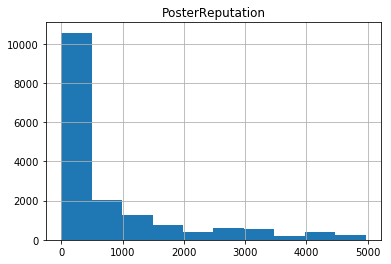

In [37]:
final_reduced_df.select("PosterReputation").where(final_reduced_df.PosterReputation<5E3).toPandas().hist()

## Filling NaNs

In [70]:
import scipy.stats as stats

In [31]:
pd_df = final_filtered_df.toPandas()

In [69]:
pd_df.PosterAge.tolist()[14] is np.nan
np.isnan(pd_df.PosterAge.tolist()[14])

True

### Poster Age

In [73]:
poster_age = pd_df.PosterAge.tolist()
clean_poster_age = [age for age in poster_age if not np.isnan(age)]
stats.normaltest(clean_poster_age)

NormaltestResult(statistic=2713.4505397977614, pvalue=0.0)

(array([  2.77000000e+02,   7.03000000e+02,   1.03800000e+03,
          1.99700000e+03,   1.18900000e+03,   1.66700000e+03,
          5.84000000e+02,   1.07400000e+03,   1.58000000e+02,
          6.85000000e+02,   1.70000000e+02,   1.80000000e+01,
          2.60000000e+01,   4.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   5.40000000e+01,
          1.00000000e+00,   3.40000000e+01]),
 array([ 14. ,  18.1,  22.2,  26.3,  30.4,  34.5,  38.6,  42.7,  46.8,
         50.9,  55. ,  59.1,  63.2,  67.3,  71.4,  75.5,  79.6,  83.7,
         87.8,  91.9,  96. ]),
 <a list of 20 Patch objects>)

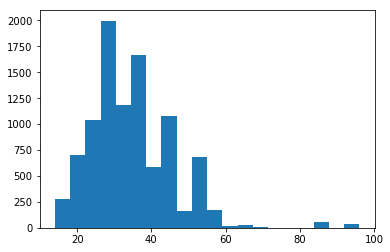

In [79]:
plt.hist(clean_poster_age, bins=20)

### Age

In [75]:
age = pd_df.Age.tolist()
clean_age = [x for x in age if not np.isnan(x)]
stats.normaltest(clean_age)

NormaltestResult(statistic=519.75619875212999, pvalue=1.3689118200136037e-113)

(array([   27.,   135.,   463.,   821.,   753.,  1030.,   463.,  1094.,
          233.,   297.,   203.,     6.,    18.,     0.,     0.,     0.,
            0.,     2.,     0.,     9.]),
 array([ 14. ,  18.1,  22.2,  26.3,  30.4,  34.5,  38.6,  42.7,  46.8,
         50.9,  55. ,  59.1,  63.2,  67.3,  71.4,  75.5,  79.6,  83.7,
         87.8,  91.9,  96. ]),
 <a list of 20 Patch objects>)

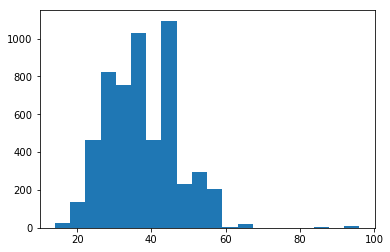

In [78]:
plt.hist(clean_age, bins=20)

### Poster Reputation

In [85]:
reputation = pd_df.PosterReputation.tolist()
clean_reputation = [x for x in reputation if not np.isnan(x)]
log_clean_reputation = [np.log(x) for x in reputation if not np.isnan(x)]
stats.normaltest(clean_reputation)

NormaltestResult(statistic=20419.671081308985, pvalue=0.0)

In [87]:
stats.f_oneway(log_clean_reputation, clean_reputation)

F_onewayResult(statistic=3291.6479331257601, pvalue=0.0)

In [93]:
var_log = stats.variation(log_clean_reputation)
var_rep = stats.variation(clean_reputation)

In [94]:
stats.f(var_log/var_rep, log_clean_reputation, clean_reputation)

In [97]:
9683/24009

0.4033070931733933

In [ ]:
stats.f

(array([[  617.,   683.,  2714.,  2710.,  3504.,  3717.,  3124.,  2347.,
           193.,     0.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
          2067.,     0.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           647.,   155.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,   213.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,   224.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,    12.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,    37.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,   553.]]),
 array([

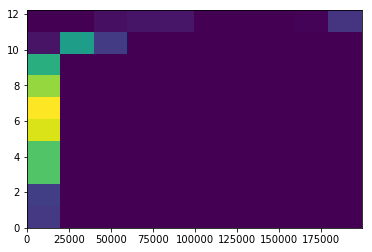

In [90]:
plt.hist2d(clean_reputation, log_clean_reputation)

(array([  1.82600000e+04,   1.34900000e+03,   9.68000000e+02,
          1.09900000e+03,   2.29000000e+02,   5.73000000e+02,
          1.50000000e+01,   1.98000000e+02,   2.24000000e+02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.20000000e+01,
          0.00000000e+00,   0.00000000e+00,   3.70000000e+01,
          0.00000000e+00,   5.53000000e+02]),
 array([  1.00000000e+00,   9.94805000e+03,   1.98951000e+04,
          2.98421500e+04,   3.97892000e+04,   4.97362500e+04,
          5.96833000e+04,   6.96303500e+04,   7.95774000e+04,
          8.95244500e+04,   9.94715000e+04,   1.09418550e+05,
          1.19365600e+05,   1.29312650e+05,   1.39259700e+05,
          1.49206750e+05,   1.59153800e+05,   1.69100850e+05,
          1.79047900e+05,   1.88994950e+05,   1.98942000e+05]),
 <a list of 20 Patch objects>)

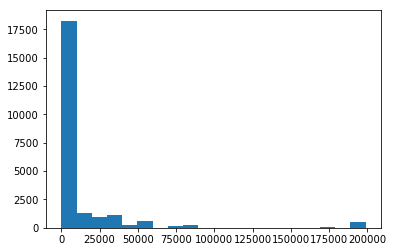

In [88]:
plt.hist(clean_reputation,bins=20)

count    9683.000000
mean       34.832283
std        11.252678
min        14.000000
25%        27.000000
50%        33.000000
75%        41.000000
max        96.000000
Name: PosterAge, dtype: float64


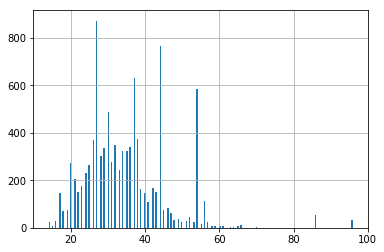

In [46]:
print(pd_df.PosterAge.describe())
pd_df.PosterAge.hist(bins=200)

count    5554.000000
mean       37.443824
std         9.477650
min        14.000000
25%        30.000000
50%        37.000000
75%        44.000000
max        96.000000
Name: Age, dtype: float64


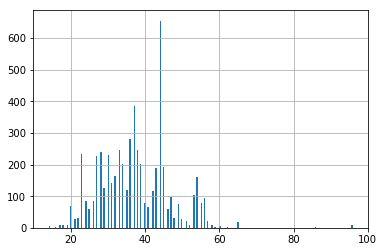

In [44]:
print(pd_df.Age.describe())
pd_df.Age.hist(bins=200)

In [33]:
print(pd_df.Age.median())
print(pd_df.Age.mean())
print(pd_df.Age.mode())

37.0
37.44382427079582
0    44.0
dtype: float64


In [34]:
import random
random.seed()

(array([  169.,   441.,   804.,  1065.,  1426.,  1686.,  1861.,  1419.,
          845.,   284.]),
 array([ 15.4029446 ,  19.85385644,  24.30476828,  28.75568012,
         33.20659197,  37.65750381,  42.10841565,  46.55932749,
         51.01023934,  55.46115118,  59.91206302]),
 <a list of 10 Patch objects>)

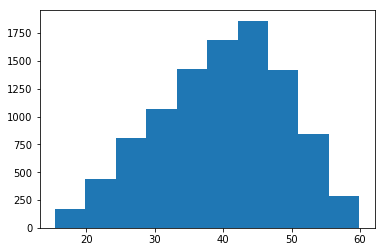

In [43]:
plt.hist([random.triangular(15, 60, 44) for i in range(10000)])

In [36]:
final_filtered_df_age = final_filtered_df.\
withColumn("Age_full",final_filtered_df.select("Age").fillna(random.triangular(15,60,44))).drop("Age")

AssertionError: col should be Column

In [ ]:
cosa = final_filtered_df.select("Age").fillna(random.triangular(15,60,44))
cosa.describe().toPandas()

In [ ]:
final_filtered_df_age.describe().toPandas()

## Grouping the categorical variables

In [ ]:
pd_df = final_filtered_df.toPandas()

In [ ]:
pd_df.cov()

In [ ]:
final_filtered_df.dropna().describe().toPandas()

In [ ]:
final_filtered_df.dropna().\
select("FinalTime","CensoringStatus","TagCount","TitleLength","UserReputation","Age","PosterReputation","PosterAge").\
write.csv("/home/mat/Escritorio/ejecucion_systemml/final_df/only_values/fileX")